# DIABETES RISK PREDICTION
* This notebook sought to create a model that can predict a person's diabetic status based on characteristics such as blood glucose levels, blood pressure and Age e.t.c. The main objectives are;
1. To find out characteristics of a person such as age and blood glucose levels relate their diabetes status.
2. To extract the relevant features from these characteristics.
3. Build a model that utilizes these features to make predictions diabetes status with high accuracy.

## 1.1 Loading and Cleaning the dataset
In machine learning, it is essential that the datset you are using have been properly preprocessed before modelling. Preprocessing include;
1. Ensuring the data is properly formatted in terms of column names and rows.
2. Ensuring there are no missing values by imputing the data.
3. Ensuring there are no duplicate rows in the data since they can cause wrong inferences.

In [19]:
# import the relevant sci-kit learn methods
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# import relevant models for visualization and analysis
from statannot import add_stat_annotation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from mlxtend.evaluate import paired_ttest_5x2cv
%matplotlib inline
_ = sns.set()

In [20]:
# load in the the dataset and view the first five rows
data = pd.read_csv(
    filepath_or_buffer='diabetes.csv'
)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


The **data has been properly formatted** in terms of the column names and positions. Now we need to check whether there are missing values. Next we check the number of rows and columns of the data

In [21]:
# check the shape of the data
data.shape

(768, 9)

There are **768** participants in this study

In [22]:
# check if there are any missing values in the data
data.isnull().sum(axis=1).sum(axis=0)

0

There are no **no missing values** in the data. Now we check for duplicate rows in the data.

In [23]:
# check for duplicates in the data
data.duplicated().sum()

0

There are **no duplicates** in the data. That is, data from a particular patient has not been recorded twice.

In [24]:
data.Outcome.dtype

dtype('int64')

In [25]:
# convert the Outcome column to string datatype for statistical analysis
data.Outcome = data.Outcome.astype('str')

## 2. Statistical Analysis and Inference
Next we perform some statistical analysis involving the various columns vs diabetes outcome. It is very important to do this so that we can know the whether there is any relationship between the characteristic and diabetes outcome. We create a function *plot_relationship* that outputs a plot and the statistical significance as p-value. We also perform descriptive statistics on each column of the data.

We first perform some descriptive statistics of the data using the mean median e.t.c.

In [26]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


We could see that most of the columns had a wide range of values and also, most of them have different scales.
Most machine learning algorithms do not perform properly with features having different scales so it would be prudent to normalize the data before training.

Next we check whether the values in each of the data column are normally distributed by using a shapiro-wilk test and a significance threshold of 0.05

In [226]:
# test for normality within the data columns
norm_p_values = {}
for col in data.columns[:-1]:
    norm_p_values[col] = stats.shapiro(data[col].values)
pd.DataFrame(norm_p_values).T.rename(columns={0:'shapiro_test_statistic', 1:'p_value'})

,shapiro_test_statistic,p_value
Pregnancies,0.904278,1.608089e-21
Glucose,0.970104,1.986761e-11
BloodPressure,0.818921,1.584007e-28
SkinThickness,0.904627,1.751576e-21
Insulin,0.722021,7.915248e-34
BMI,0.949989,1.840562e-15
DiabetesPedigreeFunction,0.836519,2.477697e-27
Age,0.874766,2.401947e-24


The values of all the columns are normally distributed since the p values of the shapiro test are all less than 0.05 Since we are comparing two groups, we can use the 2-sample independent t test.

In [224]:
def plot_relationship(y, data):
    """Make an lv plot to compare the relationship between a measured characteristic and.
    and diabetes Outcome.
    
    Args -
        y: (str) the characteristic to compare
        data: (DataFrame obj) input data containing a column with the characteristic
    Returns -
        A matplotlib.pyplot obj with pvalue indicated
    """
        # make a violin plot to check for the relationship between no of pregnancies and outcome
    _ = sns.boxplot(
        x='Outcome',
        y=y,
        data=data, orient="v")
    
    # calculate and annotate the plot with the mann-whitney u test statistic and p value
    _ = add_stat_annotation(ax=_,
                        data=data,
                        x='Outcome',
                        y=y,
                        test='t-test_ind', 
                        box_pairs=[('0', '1')],
                        text_format='full')
    
    _ = plt.xticks([0, 1], labels = ['Normal', 'Diabetic'])

We first check out the relationship between **number of pregnancies** and **diabetic outcome**. Therefore we hypothesize that,

**HO**: There is no relationship between number of pregnancies and diabetes status.

**H1**: There is a relationship between number of pregnancies and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=5.065e-10 stat=-6.298e+00


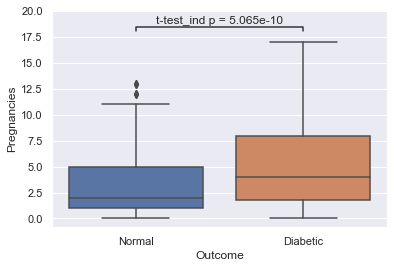

In [225]:
# check the relationship between number of pregnancies and daibetes outcome
plot_relationship('Pregnancies', data)

Fig 1: Relationship between **Number of Pregnancies** and **Diabetes**

As can be seen from the graph, the the median number of pregnancies for the diabetes postive females were slightly higher than the negatives. Since the **p value <<< 0.5**, we can reject the null hypothesis and accept the alternative hypothesis that **there is an association between number of pregnancies and diabetes**.

Next, we check the association between **age** and **diabetes**.

**HO**: There is no relationship between Age and diabetes status.

**H1**: There is a relationship between Age and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=2.210e-11 stat=-6.793e+00


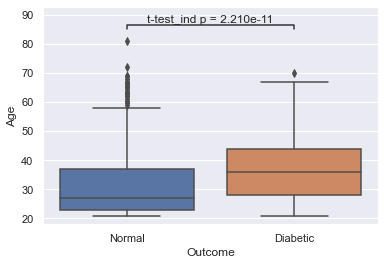

In [30]:
# make a violin plot to check for the relationship between age and outcome
plot_relationship('Age', data)

Fig 2: Relationship between **Age** and **Diabetes**

As can be seen from the graph, the median age for the diabetic females were slightly higher than the negatives. Since the **p value <<< 0.5**, we can reject the null hypothesis and accept the alternative hypothesis that **there is an association age and diabetes**.

Next, we check the association between **Glucose** and **diabetes**.

**HO**: There is no relationship between Glucose and diabetes status.

**H1**: There is a relationship between Glucose and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=8.935e-43 stat=-1.460e+01


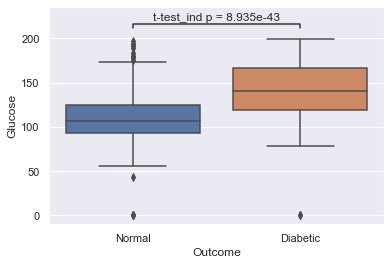

In [31]:
plot_relationship('Glucose', data)

Fig 3: Relationship between **Glucose** and **Diabetes**

As can be seen from the graph, the median glucose levels for the diabetic females were slightly higher than the normal. Since the **p value < 0.5**, we can reject the null hypothesis and accept the alternative hypothesis that **there is an association glucose and diabetes**.

Next, we check the association between **Blood Pressure** and **diabetes**.

**HO**: There is no relationship between Blood Pressure and diabetes status.

**H1**: There is a relationship between Blood Pressure and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=7.151e-02 stat=-1.805e+00


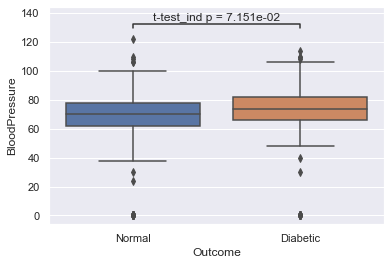

In [32]:
plot_relationship('BloodPressure', data)

Fig 4: Relationship between **Blood Pressure** and **Diabetes**

As can be seen from the graph, the median blood pressure levels for the diabetic females were slightly higher than the normal. Since the **p value > 0.5**, we cannot reject the null hypothesis and accept the alternative hypothesis that **there is an association Blood Pressure and diabetes**.

Next, we check the association between **Skin thickness** and **diabetes**.

**HO**: There is no relationship between Skin thickness and diabetes status.

**H1**: There is a relationship between Skin thickness and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=3.835e-02 stat=-2.075e+00


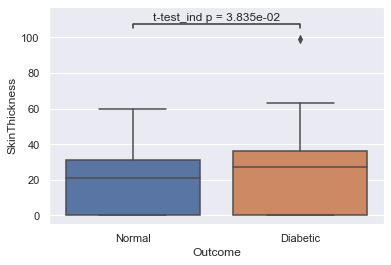

In [33]:
plot_relationship('SkinThickness', data)

Fig 5: Relationship between **Skin thickness** and **Diabetes**

As can be seen from the graph, the median skin thickness for the diabetic females were slightly higher than the normal. Since the **p value < 0.5**, we can reject the null hypothesis and accept the alternative hypothesis that **there is an association Skin thickness and diabetes**.

Next, we check the association between **Insulin** and **diabetes**.

**HO**: There is no relationship between insulin and diabetes status.

**H1**: There is a relationship between Insulin and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=2.862e-04 stat=-3.644e+00


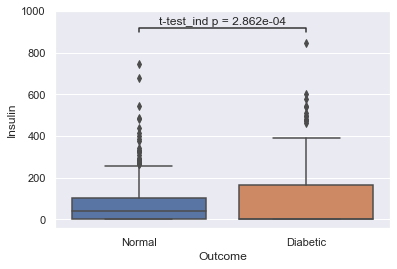

In [34]:
plot_relationship('Insulin', data)

Fig 6: Relationship between **Insulin** and **Diabetes**

As can be seen from the graph, the median Insulin for the diabetic females were slightly lower than the normal. Since the **p value < 0.5**, we can accept the alternative hypothesis and reject the null hypothesis that **there is no association between Insulin and diabetes**.

Next, we check the association between **BMI** and **diabetes**.

**HO**: There is no relationship between BMI and diabetes status.

**H1**: There is a relationship between BMI and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=1.230e-16 stat=-8.472e+00


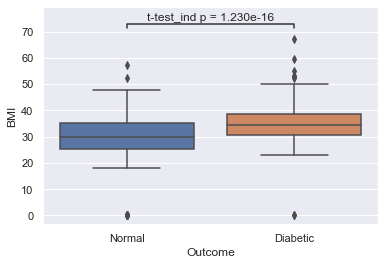

In [35]:
plot_relationship('BMI', data)

Fig 7: Relationship between **BMI** and **Diabetes**

As can be seen from the graph, the median BMI for the diabetic females were slightly higher than the normal. Since the **p value < 0.5**, we can reject the null hypothesis and accept the alternative hypothesis that **there is an association BMI and diabetes**.

Next, we check the association between **Diabetes Pedigree Function** and **diabetes**.

**HO**: There is no relationship between Diabetes Pedigree Function and diabetes status.

**H1**: There is a relationship between Diabetes Pedigree Function and diabetes status.

0 v.s. 1: t-test independent samples with Bonferroni correction, P_val=1.255e-06 stat=-4.886e+00


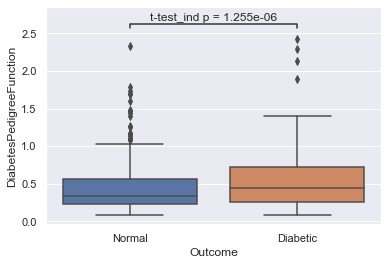

In [36]:
plot_relationship('DiabetesPedigreeFunction', data)

Fig 8: Relationship between **Diabetes Pedigree Function** and **Diabetes**

As can be seen from the graph, the median Diabetes Pedigree Function for the diabetic females were slightly higher than the normal. Since the **p value < 0.5**, we can reject the null hypothesis and accept the alternative hypothesis that **there is an association Diabetes Pedigree Function and diabetes**.

### 3. Data Processing and Feature Engineering
We first start our model training and evaluation with building and evaluating a baseline classification model. Research shows that DummyClassifier is the most suitable for this. So we use it to get a baseline performance of our model
#### 3.1 Baseline Classification with DummyClassifier

In [37]:
# ensure all the columns have number dtype
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                      object
dtype: object

The Outcome column is of datatype object. Therefore before training, we would need to change it to int or float type. We check the performance of our base model on the entire dataset. We used the 'uniform' strategy so that we can know the accuracy when we make random predictions. This is good because if we get a model with a far better accuracy, we could be confident that the model did not do random predictions, but instead was properly trained.

dummy_precision = 0.3597246563490549
dummy_recall_score = 0.49301994301994306
fischer_test_statisitc = 1.24053826745164, pvalue = 0.6092738627363959


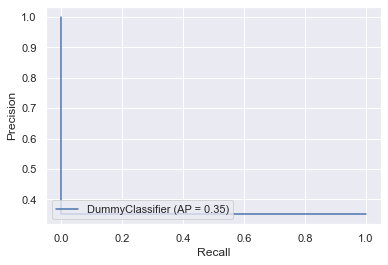

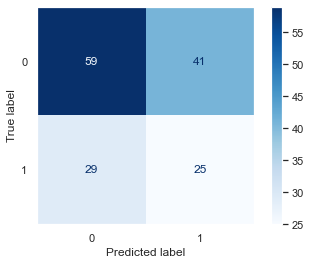

In [243]:
# create feature matrix X and response vector y
X = data.drop('Outcome', axis=1)
y = np.ravel(
        LabelBinarizer().fit_transform(data.Outcome)) # use LabelBinarizer to convert to numerical dtype

# instantiate the GaussianNB classifier
dummy_clf_base = DummyClassifier(strategy='uniform')

# calculate the 10-fold cross validated accuracy
print(
    'dummy_precision = {}'.format(
        cross_val_score(estimator=dummy_clf_base, X=X, y=y, cv=10, scoring='precision').mean()))
print(
    'dummy_recall_score = {}'.format(
        cross_val_score(estimator=dummy_clf_base, X=X, y=y, cv=10, scoring='recall').mean()))

# check the precision_recall curve of the dummy classifier
X = data.drop('Outcome', axis=1)
y = data.Outcome.astype('int')

# create train and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

dummy_clf_base.fit(XTrain, yTrain)
# plot precision_recall curve for dummy classifier
metrics.plot_precision_recall_curve(dummy_clf_base, XTest, yTest)

# plot confusion matrix for dummy classifer
dummy_disp = metrics.plot_confusion_matrix(dummy_clf_base, XTest, yTest, cmap='Blues')

# turn off grid lines
plt.grid(False)

# perform a fischer exact test
fish, pval = stats.fisher_exact(dummy_disp.confusion_matrix)
print(
    'fischer_test_statisitc = {}, pvalue = {}'.format(fish, pval))

We achieved a recall of about 51% when a dummy classifier was used. We would use this as a benchmark model to compare the performances of other classifiers to.

Next, we do preprocessing and feature engineering on our dataset to prepare it for training and evaluation. The steps to be used are;
1. Removal of Outliers in the data
2. Perform feature engineering using transforms such as Polynomials and Scalers
3. Performing feature selection using dimensionality reduction
4. Fine tuning Hyperparamters using GridSearchCV and RandomizedSearchCV
5. Adjust the threshold of the classifier

#### 3.2 Removal of Outliers
We use Tukey's method of outlier removal for this. This is done by removing values beyond than 1.5 times the interquartile range on either quartile. However, we would want to drop rows with outliers in more than two columns. A little helper function is used for this.

In [39]:
# helper function to remove outliers from columns
def detect_outliers(df,n,features):
    """Detects outliers rows with 'n' outliers using the Tukey method.
    
        Args -
            df: DataFrame to be checked for outliers
            n: Threshold of outliers to be considered for dropping
            features: columns to be considered for outlier checking
        Returns -
            A list of indices of rows with > n outliers
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | 
                              (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
   
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)  

    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [40]:
# obtain rows with more than two ouliers
detect_outliers(df=data, n=2, features=data.columns[:-1])

[]

Since there are no rows with more than two outliers, we drop none of them, We move on to the step which is feature engineering and selection.

#### 3.3 Feature Engineering
Next we check the effects of some preprocessing steps on the features on performance of the model. We use a paired ttest with an alpha level of 0.05

In [41]:
def feature_eng_sig(data, feat_transformer, clf, cols, random_seed=None):
    """Calculate the significance of a transformation on selected features
    
        Args -
            data: (DataFrame) dataset to make analysis on
            feat_transformer: (sklearn.transformer) transformer object to fit_transform features
            clf: (sklearn classifier) classifier object which can fit_predict
            cols: (list) list of columns to test
            random_seed: (default=None) can be set to any integer. Controls reproducibility of analysis
            
        Returns -
            A pandas series of columns with associated p values
    """
    p_values = {}
    for col in cols:    
        # create feature matrix X and response vector y
        X = pd.DataFrame(data[col])
        y = np.ravel(
            LabelBinarizer().fit_transform(data.Outcome)) # use LabelBinarizer to convert to numerical dtype    
    
        # create a pipeline
        pipe = Pipeline(steps=[('feat_transformer', feat_transformer),
                               ('dummy', clf)])
        
    
        # calculate the statistical significance of using polynomial features
        _, p_values[col] = paired_ttest_5x2cv(estimator1=clf,
                                              estimator2=pipe,
                                              X=X,
                                              y=y,
                                              scoring='accuracy',
                                              random_seed=random_seed
                                             )
                    

    return(pd.Series(p_values))

First, we check if the use of polynomial features improves any of the models. We use the paired t-test and set alpha level to be 0.05.

**H0**: 2nd degree Polynomial features have no effect on model performance

**H1**: 2nd degree Polynomial features have an effect on model performance

In [42]:
# instantiate a transformer and a classifier
poly_feat = PolynomialFeatures(degree=2, include_bias=False)
clf = DummyClassifier(strategy='uniform')

# test the significance of transformation with polynomial features
feature_eng_sig(data, poly_feat, clf, data.columns[:-1], random_seed=1)

Pregnancies                 0.858092
Glucose                     0.898907
BloodPressure               0.133586
SkinThickness               0.727234
Insulin                     0.338069
BMI                         0.452504
DiabetesPedigreeFunction    0.369305
Age                         0.305193
dtype: float64

None of the p-values was < 0.05 so we cannot reject the null hypothesis and hence we can conclude that the use of polynomial features has no effect on model performance.

In [43]:
# instantiate a transformer and a classifier
mm_scaler = StandardScaler()
clf = DummyClassifier(strategy='uniform')

# test the significance of transformation with transformer
feature_eng_sig(data, mm_scaler, clf, data.columns[:-1], random_seed=1)

Pregnancies                 0.211876
Glucose                     0.877127
BloodPressure               0.300823
SkinThickness               0.788428
Insulin                     0.131877
BMI                         0.430530
DiabetesPedigreeFunction    0.951702
Age                         0.751666
dtype: float64

In [44]:
# create feature matrix X and response vector y
X = data.drop('Outcome', axis=1)
y = np.ravel(
        LabelBinarizer().fit_transform(data.Outcome)) # use LabelBinarizer to convert to numerical dtype

# instantiate a transformer and a classifier
pca = PCA()
clf = DummyClassifier(strategy='uniform')

# test the significance of transformation with transformer
pipe = Pipeline(steps=[('feat_transformer', pca),
                               ('clf', clf)])

paired_ttest_5x2cv(estimator1=clf,
                   estimator2=pipe,
                   X=X,
                   y=y,
                   scoring='accuracy'
                  )

(-2.845823262126388, 0.03599961818909442)

Since PCA transformation is proving promising, we would visualize how the data is clustered by visualising the first two principal components

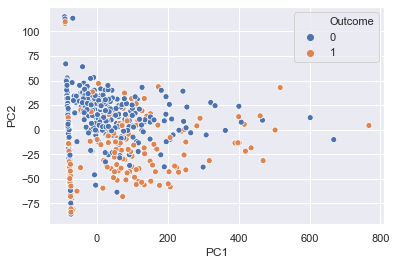

In [45]:
## extract the first two principal components
# instantiate the pca transformer
pca = PCA(n_components=2)

# fit transform the data
pca_comp_2 = pca.fit_transform(data.drop('Outcome', axis=1))

# make a plot of the first two principal components
_ = sns.scatterplot(x=pca_comp_2[:,0],
                y=pca_comp_2[:,1],
                hue=data.Outcome)
_ = plt.xlabel('PC1')
_ = plt.ylabel('PC2')

This shows class imbalance where there are more points of class 0 than class 1. Also it could be seen that points of class 0 cluster very weel with those of class 1 interspersed among the class 0 points. We can confirm class imbalance by also counting the number of points for each class.

In [46]:
# determine the number of points for each class
data.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

It could be seen above that the number of class 0 points are almost twice that of class 1 points. Hence there is class imbalance. Therefore, we need to ensure we take into account, class imbalance during training and evaluation. Also, in this situation, class accuracy would not be an ideal metric for this task instead, we would use precision-recall score as our metric.

#### 3.4 Points noted from preprocessing and feature engineering
* Polynomial features preprocessing did not have any significant effect on the performance of our model hence would not be used for final preprocessing.
* Feature scaling did not have any significant effect on the performance of our model. However, it would still be used to preprocess the features since some some algorithms like logistic regression work better with scaled features.
* PCA transformation improved the performance of our base model hence would be considered for the training of the final model.
* Class imbalance exists in our data hence will be taken into account during model training.
* precision_recall score will now be used as the evaluation metric instead of accuracy score.

## 4. Model Training and Evaluation
We now 
* perform the final preprocessing of our data.
* train our model.
* Train and evaluate our model using recall_score, and searching for optimal hyperparameters using GridSearchCV
* Algorithms to use for Voting Classifier
    1. LogisticRegression
    2. BernoulliNB
    3. SVC

In [66]:
# set feature matrix X and response vector y
X = data.drop('Outcome', axis=1)
y = data.Outcome.astype('int')

# instantiate the transformers and  logistic regression classsifier
robust_scaler = RobustScaler()
pca = PCA()
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

pipe_lr = Pipeline(steps=[('rbs', robust_scaler),
                ('pca', pca),
                ('logreg', logreg)
               ])

param_grid = {'rbs__with_centering': [True, False],
              'rbs__with_scaling': [True, False],
              'pca__n_components': [2, 3, 4, 5, 6, 7],
              'logreg__C': [0.1, 1, 10],
              'logreg__penalty': ['l1', 'l2']
             }

grid_lr = GridSearchCV(estimator=pipe_lr,
                    param_grid=param_grid,
                    scoring='recall',
                    cv=5
                      )

grid_lr.fit(X, y)

print('The best parameters for logistic regression are: {}'.format(grid_lr.best_params_))
print()
print('With a recall score of: {}'.format(grid_lr.best_score_))

The best parameters are: {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'pca__n_components': 6, 'rbs__with_centering': True, 'rbs__with_scaling': True}

With a recall score of: 0.7689727463312369


In [67]:
# instantiate the transformers and classsifier
from sklearn.svm import SVC
robust_scaler = RobustScaler()
pca = PCA()
svc = SVC(class_weight='balanced')

pipe_svc = Pipeline(steps=[('rbs', robust_scaler),
                ('pca', pca),
                ('svc', svc)
               ])

param_grid = {'rbs__with_centering': [True, False],
              'rbs__with_scaling': [True, False],
              'pca__n_components': [2, 3, 4, 5, 6, 7],
              'svc__C': [0.1, 1, 10],
              
             }

grid_svc = GridSearchCV(estimator=pipe_svc,
                    param_grid=param_grid,
                    scoring='recall',
                    cv=5
                   )

grid_svc.fit(X, y)

print('The best parameters for SVC are: {}'.format(grid_svc.best_params_))
print()
print('With a recall score of: {}'.format(grid_svc.best_score_))

The best parameters for SVC are: {'pca__n_components': 5, 'rbs__with_centering': True, 'rbs__with_scaling': True, 'svc__C': 0.1}

With a recall score of: 0.8099231306778476


In [74]:
# instantiate the transformers and classsifier
from sklearn.naive_bayes import BernoulliNB
robust_scaler = RobustScaler()
pca = PCA()
bnb = BernoulliNB()

pipe_bnb = Pipeline(steps=[('rbs', robust_scaler),
                ('pca', pca),
                ('bnb', bnb)
               ])

param_grid = {'rbs__with_centering': [True, False],
              'rbs__with_scaling': [True, False],
              'pca__n_components': [2, 3, 4, 5, 6, 7],
              'bnb__fit_prior': [True, False],
              
             }

grid_bnb = GridSearchCV(estimator=pipe_bnb,
                    param_grid=param_grid,
                    scoring='recall',
                    cv=5
                   )

grid_bnb.fit(X, y)

print('The best parameters for BernoulliNB are: {}'.format(grid_bnb.best_params_))
print()
print('With a recall score of: {}'.format(grid_bnb.best_score_))

The best parameters for BernoulliNB are: {'bnb__fit_prior': False, 'pca__n_components': 7, 'rbs__with_centering': True, 'rbs__with_scaling': False}

With a recall score of: 0.7540181691125089


In [197]:
# create classfier pipelines with best parameters from grid search cv
# logistic regression
rbs_lr = RobustScaler(with_centering=True, with_scaling=True)
pca_lr = PCA(n_components=6)
logreg = LogisticRegression(C=0.1, penalty='l1', class_weight='balanced', solver='liblinear')

pipe_lr = Pipeline(steps=[('rbs_lr', rbs_lr),
                          ('pca_lr', pca_lr),
                          ('logreg', logreg)
                         ])

# bernoulli naive bayes
rbs_bnb = RobustScaler(with_centering=True, with_scaling=False)
pca_bnb = PCA(n_components=7)
bnb = BernoulliNB(fit_prior=False)

pipe_bnb = Pipeline(steps=[('rbs_bnb', rbs_bnb),
                           ('pca_bnb', pca_bnb),
                           ('bnb', bnb)
                          ])

# SVC 
rbs_svc = RobustScaler(with_centering=True, with_scaling=True)
pca_svc = PCA(n_components=5)
svc = SVC(C=0.1, probability=True)

pipe_svc = Pipeline(steps=[('rbs_svc', rbs_svc),
                           ('pca_svc', pca_svc),
                           ('svc', svc)
                          ])
vc = VotingClassifier(estimators=[('lr', grid_lr.best_estimator_),
                                  ('bnb', grid_bnb.best_estimator_),
                                  ('svc', pipe_svc)],
                      voting='soft'
                     )

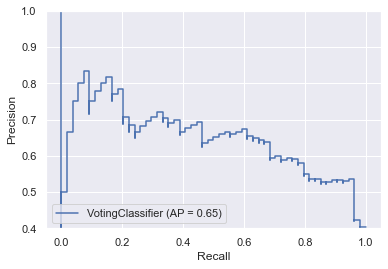

In [205]:
# check the precision_recall curve of the voting classifier model
X = data.drop('Outcome', axis=1)
y = data.Outcome.astype('int')

# create training and test data
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# fit the model with the data
vc.fit(XTrain, yTrain)

# plot precision_recall_curve
metrics.plot_precision_recall_curve(vc, XTest, yTest)
_ = plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
_ = plt.ylim(0.4, 1.0)

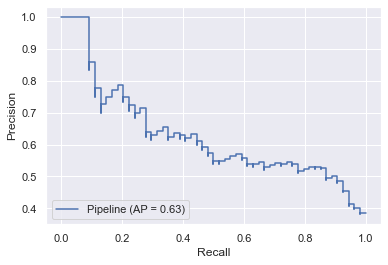

In [214]:
# check the precision_recall curve of the voting classifier model
X = data.drop('Outcome', axis=1)
y = data.Outcome.astype('int')

# create train and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

grid_svc.best_estimator_.fit(XTrain, yTrain)
# plot precision_recall curve for best SVC estimator
metrics.plot_precision_recall_curve(grid_svc.best_estimator_, XTest, yTest)

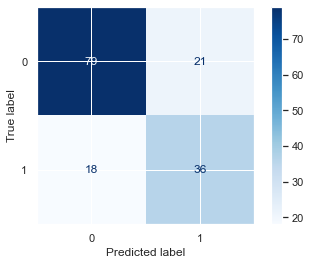

In [211]:
# plot confusion_matrix for best voting classifier
metrics.plot_confusion_matrix(vc, XTest, yTest, cmap='Blues')

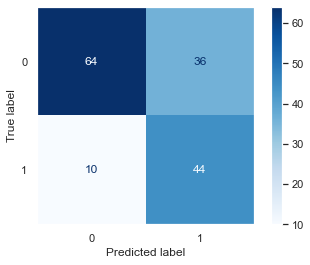

In [233]:
# plot confusion_matrix for best svc
disp = metrics.plot_confusion_matrix(grid_svc.best_estimator_, XTest, yTest, cmap='Blues', values_format='.3g')
_ = plt.grid(False)

From the confusion_matrix, it could be seen that the svc model had the lesser false positives which we want to minimize. So we use the svc model as our final model.

In [215]:
final_model = grid_svc.best_estimator_.fit(X, y)

In [216]:
final_model

Pipeline(steps=[('rbs', RobustScaler()), ('pca', PCA(n_components=5)),
                ('svc', SVC(C=0.1, class_weight='balanced'))])

we can also use a fischers exact test bto determine if the observed values we are seeinng in the confusion matrix are not just random observations

In [235]:
# calculate the fischers exact statistic for the final model
fiscer_value, p = stats.fisher_exact(disp.confusion_matrix)
print(
    'fischers_test-statistic = {}, p_value = {}'.format(fiscer_value, p))

fischers_test-statistic = 7.822222222222222, p_value = 4.6680253177079705e-08


Since p value <<< 0.05, it shows that the observed frequenceies in the confusion matrix are not by random chance.
Therfore, this final_model is the best for our purposes